# Core-valence separation

For the calculation of [X-ray absorption spectra](../tutorials/xray_calc) the core-excited states are embedded in the continuum of valence-ionized states. This means that the targetted core-excited states cannot easily be resolved with, e.g., a Davidson approach, as a large number of valence-excited and -ionized states need to be converged first. In order to alleviate this issue, the core-valence separation (CVS) approach has been developed, for which states the weak coupling between core- and valence-excitations are neglected, leading to a new pseudo-eigenvalue equation of lower dimensionality, and for which the first few eigenstates are now core-excitations:

$$
\left(
\begin{array}{cc}
\mathbf{A} & \mathbf{B} \\
[\mathbf{B}^{\ast} & [\mathbf{A}^{\ast}
\end{array}
\right) ^{\mathrm{CVS}}
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) ^{\mathrm{CVS}}
= \omega^{\mathrm{CVS}}
\left(
\begin{array}{cc}
\mathbf{1} & \mathbf{0} \\
\mathbf{0} & \mathbf{-1}
\end{array}
\right) ^{\mathrm{CVS}}
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) ^{\mathrm{CVS}}
$$

with matrix blocks

\begin{align*}
A_{Ia,jb}  &= \delta_{Ij} \delta_{ab} (\epsilon_a - \epsilon_I) + (Ia|jb) - c_{\textrm{HF}}(Ij|ab) + (1-c_{\textrm{HF}})(Ia|f_{\textrm{xc}}|jb)
\\
B_{Ia,jb}  &= (Ia|bj) - c_{\textrm{HF}}(Ib|aj) + (1-c_{\textrm{HF}})(Ia|f_{\textrm{xc}}|bj)
\end{align*}

with $I$ restricted to the core orbitals(s).

As a test, we calculate the X-ray absorption spectrum of water, considering the full and reduce RPA.

In [1]:
import copy
import adcc
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

au2ev = 27.211386

[thomas-Latitude-5580:157036] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [2]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

basis = "6-31G"
vlx_mol = vlx.Molecule.read_molecule_string(water_mol_str)
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(vlx_mol, vlx_bas)

* Info * Reading basis set from file: /home/thomas/miniconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
               

## Full-space results

For the full-space results, we construct the Hessian and property gradients:

In [3]:
lr_eig_solver = vlx.LinearResponseEigenSolver()
lr_eig_solver.update_settings(scf_settings, method_settings)

lr_solver = vlx.LinearResponseSolver()
lr_solver.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lr_eig_solver.get_e2(vlx_mol, vlx_bas, scf_results)

# Property gradients for dipole operator
V1_x, V1_y, V1_z = lr_solver.get_prop_grad("electric dipole", "xyz", vlx_mol, vlx_bas, scf_results)

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2 * c)
S2[c : 2 * c, c : 2 * c] *= -1

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Processing Fock builds... (batch size: 160)                                                                      
* Info *   batch 1/1                                                                                                      


Calculating the excitation energies and oscillator strengths:

In [4]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2)  # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    Xf = X[:, j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x) ** 2 + np.dot(Xf, V1_y) ** 2 + np.dot(Xf, V1_z) ** 2
    fosc.append(tm * 2.0 / 3.0 * eigs[j])

## CVS-space results

The dimensions of the CVS-space:

In [5]:
# Number of virtuals
nocc = vlx_mol.number_of_alpha_electrons()
nvirt = vlx.MolecularBasis.get_dimensions_of_basis(vlx_bas, vlx_mol) - nocc
n = nocc * nvirt

# CVS space
res_mo = 1
res_indx = 0
c = res_mo * nvirt

Hessian and property gradients:

In [6]:
# Define starting index for deexcitation
c_int_deex = n + res_indx

# CVS Hessian
E2_cvs = np.zeros((2 * c, 2 * c))
E2_cvs[0:c, 0:c] = E2[res_indx:c, res_indx:c]
E2_cvs[0:c, c : 2 * c] = E2[res_indx:c, c_int_deex : c_int_deex + c]
E2_cvs[c : 2 * c, 0:c] = E2[c_int_deex : c_int_deex + c, res_indx:c]
E2_cvs[c : 2 * c, c : 2 * c] = E2[
    c_int_deex : c_int_deex + c, c_int_deex : c_int_deex + c
]

# CVS overlap matrix
S2_cvs = np.identity(2 * c)
S2_cvs[c : 2 * c, c : 2 * c] *= -1

# CVS property gradients
V1_cvs_x = np.zeros(2 * c)
V1_cvs_x[0:c] = V1_x[res_indx:c]
V1_cvs_x[c : 2 * c] = V1_x[c_int_deex : c_int_deex + c]
V1_cvs_y = np.zeros(2 * c)
V1_cvs_y[0:c] = V1_y[res_indx:c]
V1_cvs_y[c : 2 * c] = V1_y[c_int_deex : c_int_deex + c]
V1_cvs_z = np.zeros(2 * c)
V1_cvs_z[0:c] = V1_z[res_indx:c]
V1_cvs_z[c : 2 * c] = V1_z[c_int_deex : c_int_deex + c]

Calculating energies and intensities:

In [7]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2_cvs)  # for clarity - is identical
M = np.matmul(Sinv, E2_cvs)
eigs_cvs, X_cvs = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs_cvs)
eigs_cvs = np.array(eigs_cvs)[idx]
X_cvs = np.array(X_cvs)[:, idx]

# Compute oscillator strengths
fosc_cvs = []
for i in range(int(len(eigs_cvs) / 2)):
    j = i + int(len(eigs_cvs) / 2)  # focus on excitations
    Xf_cvs = X_cvs[:, j]
    Xf_cvs = Xf_cvs / np.sqrt(np.matmul(Xf_cvs.T, np.matmul(S2_cvs, Xf_cvs)))
    tm_cvs = (
        np.dot(Xf_cvs, V1_cvs_x) ** 2
        + np.dot(Xf_cvs, V1_cvs_y) ** 2
        + np.dot(Xf_cvs, V1_cvs_z) ** 2
    )
    fosc_cvs.append(tm_cvs * 2.0 / 3.0 * eigs_cvs[j])

### From VeloxChem

The CVS-space approach is implemented in VeloxChem and can be done by the ``LinearResponseEigenSolver`` class. To run CVS calculation, set ``core_excitation`` to True and ``num_core_orbitals`` to the number of core orbitals to be included.

In this example we only need to include one core orbital (O1s in water molecule).

In [8]:
lr_eig_solver.core_excitation = True
lr_eig_solver.num_core_orbitals = 1
lr_eig_solver.nstates = 3
vlx_cvs_results = lr_eig_solver.compute(vlx_mol, vlx_bas, scf_results)

                                                                                                                          
                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 3                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-06                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                

## Comparison

Comparing the obtained spectra:

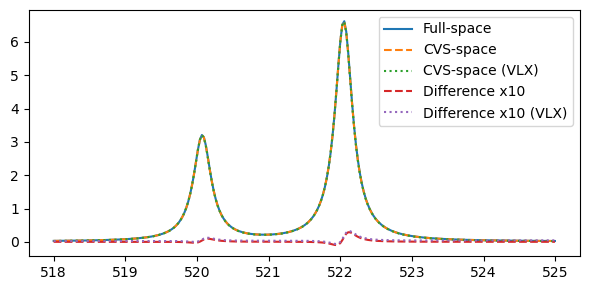

In [9]:
plt.figure(figsize=(6,3))

x, y = eigs[int(len(eigs) / 2) :], fosc
x1, y1 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x1 * au2ev, y1)

x, y = eigs_cvs[int(len(eigs_cvs) / 2) :], fosc_cvs
x2, y2 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x2 * au2ev, y2, linestyle='--')

x, y = vlx_cvs_results['eigenvalues'], vlx_cvs_results['oscillator_strengths']
x3, y3 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x3 * au2ev, y3, linestyle=':')

plt.plot(x1 * au2ev, 10*(y1 - y2), linestyle='--')
plt.plot(x1 * au2ev, 10*(y1 - y3), linestyle=':')

plt.legend(("Full-space", "CVS-space", "CVS-space (VLX)", "Difference x10", "Difference x10 (VLX)"))
plt.tight_layout()
plt.show()

Or considering the results for the *full* set of eigenstates:

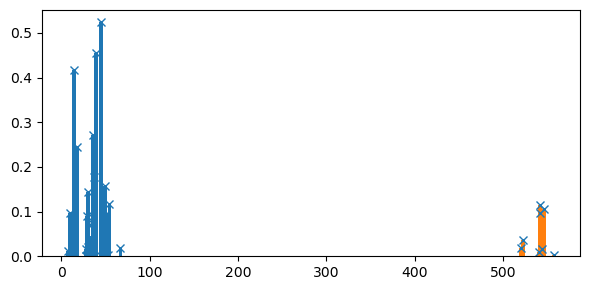

In [16]:
plt.figure(figsize=(6,3))
plt.bar(27.2114*eigs[int(len(eigs) / 2) :], fosc, width=4.0)
plt.bar(27.2114*eigs_cvs[int(len(eigs_cvs) / 2) :], fosc_cvs, width=4.0)
plt.plot(27.2114*eigs[int(len(eigs) / 2) :], fosc, 'x')

plt.tight_layout()
plt.show()

Where we see that, as expected, the full-space results have many states at lower energies, but essentially the same at high (core-excitation) energies.